In [18]:
import pandas as pd
import plotnine as pn
import numpy as np

from tqdm import tqdm

In [19]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,41.100833,0.679679,109,0.000000,False,1ccf300b3f4965f831a41232ba4b7c0c3c90d929,2020,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
1,38.076275,0.721620,88,61.625000,False,1d4e43c1be145f6711ec00af900a8658d82623a0,2012,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
2,41.553209,0.708944,69,8.200000,False,16e772e28b3470cb0050328c6e5a500882ff15ae,2015,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
3,30.062907,0.686039,179,0.000000,False,0bc5bf8a556f158b1bdaada28ce9cbd28c5d55a4,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
4,39.494263,0.681023,55,3.000000,False,35d7b77f2a6436124346d80aabc4bd66d5e0bd8b,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
149972,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
149973,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics
149974,181.720839,0.733839,8,0.000000,False,aa87aea86277064807b2a5123456c36a07db9164,1984,S2,SciBERT,Andre2018,Mathematics
149975,34.624962,0.677309,16,0.000000,False,7eef2cd2385ebf010af1f5eae1a6b58dedfd650d,2021,S2,SciBERT,Andre2018,Mathematics


In [20]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [21]:
# df = df_all[df_all["citations_per_year"] > 0]
df = df_all[df_all["density"] < 100] # hacky
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/92397243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/92397243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 20) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    log_cpy_bins = df[["log_cpy", "density_bin"]]    

    ents = [
        entropy_estimator(
            observations=log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # forget about entropy, we have a continuous variable so look at variance instead
    variances = [
            np.nanvar(
            log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    # and median
    medians = [
            np.nanmedian(
            log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    

    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(
            bins, 
            df.density_bin.value_counts(sort=False, normalize=True), 
            df.density_bin.value_counts(sort=False, normalize=False),
            ents, 
            variances,
            medians,
            ),
        columns=[
            "density_bin", 
            "freq", 
            "count", 
            "log_cpy entropy", 
            "log_cpy variance",
            "log_cpy median",
        ],
    )
    df_ent["field"] = field

    return df_ent


In [23]:
# Zach's algo

def get_df_var(df_in: pd.DataFrame, field: str, num_bins = 100, n_bin = 100) -> pd.DataFrame:
    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # TODO: can we annotate the percentiles for these bins?
    

    # n_bin = 200 # play with this
    # sample_size = 200

    d_bins = df.density_bin.unique()
    data = []

    for d_bin in d_bins:
        df_bin: pd.DataFrame = df[df["density_bin"] == d_bin]
        n_in_density_bin = len(df_bin)
        n_steps = int(n_in_density_bin / n_bin)
        data_sorted_by_cpy = df_bin.sample(frac=1)
        

        for step in range(0, n_steps, n_bin):
            # data_sorted_by_cpy = df_bin.sort_values("citations_per_year")
            # if sample_size > len(df_bin):
                # raise Exception
            # data_sorted_by_cpy = df_bin.sample(frac=1)
            # print("ALL OBSERVATIONS: ", data_sorted_by_cpy)
            if n_bin > len(df_bin):
                raise Exception
            data_to_bin = df_bin.sample(n_bin)
            # data_to_bin = data_sorted_by_cpy[step: step + n_bin]

            var_cpy_in_density_bin = np.nanvar(data_to_bin["citations_per_year"])
            var_log_cpy_in_density_bin = np.nanvar(data_to_bin["log_cpy"])

            median_density_in_density_bin = np.nanmedian(data_to_bin["density"])
            median_cpy_in_density_bin = np.nanmedian(data_to_bin["citations_per_year"])
            median_log_cpy_in_density_bin = np.nanmedian(data_to_bin["log_cpy"])

            data.append(
                (
                    median_density_in_density_bin, 
                    median_cpy_in_density_bin,
                    median_log_cpy_in_density_bin,
                    var_cpy_in_density_bin,
                    var_log_cpy_in_density_bin,
                    field,
                )
            )
    
    return pd.DataFrame(
        data,
        columns=[
            "density_med_bin", 
            "cpy_med_bin", 
            "log_cpy_med_bin",
            "cpy_var",
            "log_cpy_var", 
            "field",
        ],
    )


get_df_var(df, "Physics", n_bin=10)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,density_med_bin,cpy_med_bin,log_cpy_med_bin,cpy_var,log_cpy_var,field
0,41.159796,5.266667,0.743333,12.519595,0.057538,Physics
1,41.101622,3.480769,0.649485,87.538737,0.212774,Physics
2,41.234525,6.200000,0.792166,19.038149,0.105651,Physics
3,41.189215,3.812500,0.732394,215.011314,0.190407,Physics
4,41.282757,1.250000,0.820555,24.443416,0.069331,Physics
...,...,...,...,...,...,...
189,50.744933,0.000000,1.198390,58.869167,0.129901,Physics
190,18.435183,0.000000,1.093422,33.040903,0.176201,Physics
191,21.185968,0.250000,0.452298,4.378889,0.143275,Physics
192,19.837733,0.300000,0.132626,4.632870,0.178851,Physics


#### New scatterplot with trendlines

Why are the trends so robustly U-shaped?

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:49: RuntimeWarning: All-NaN slice encountered
/

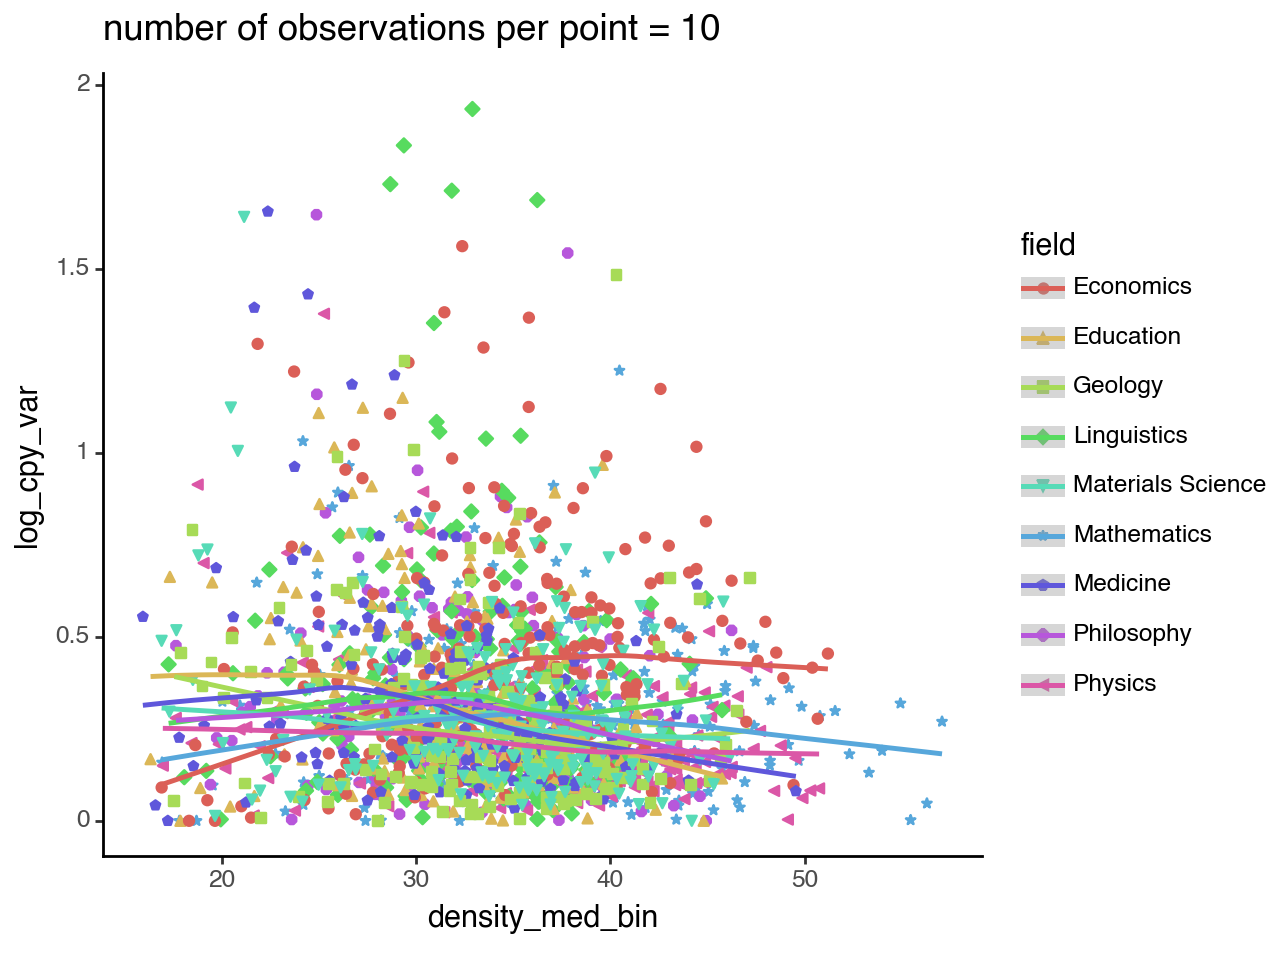

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

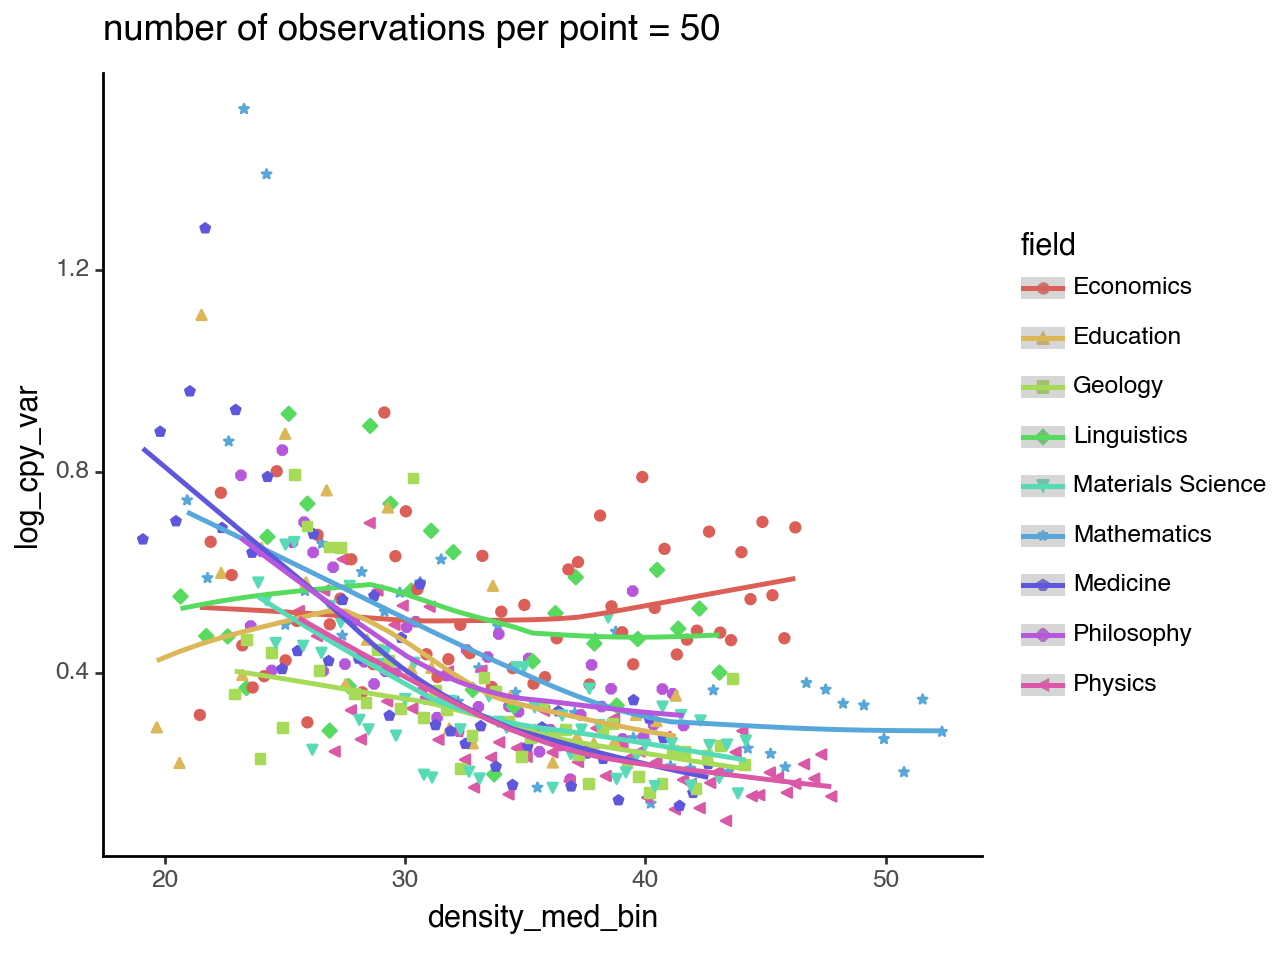

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

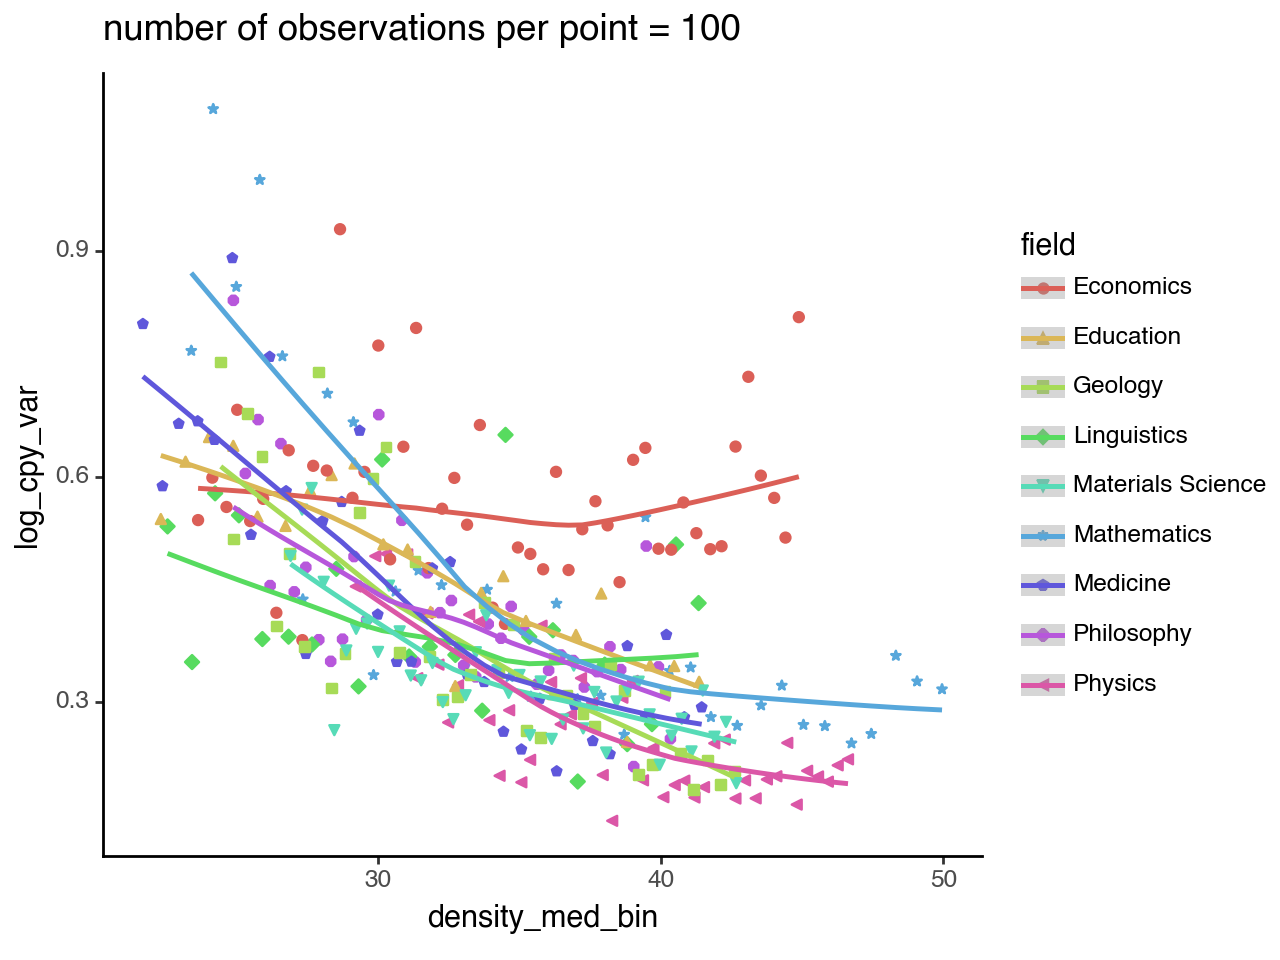

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

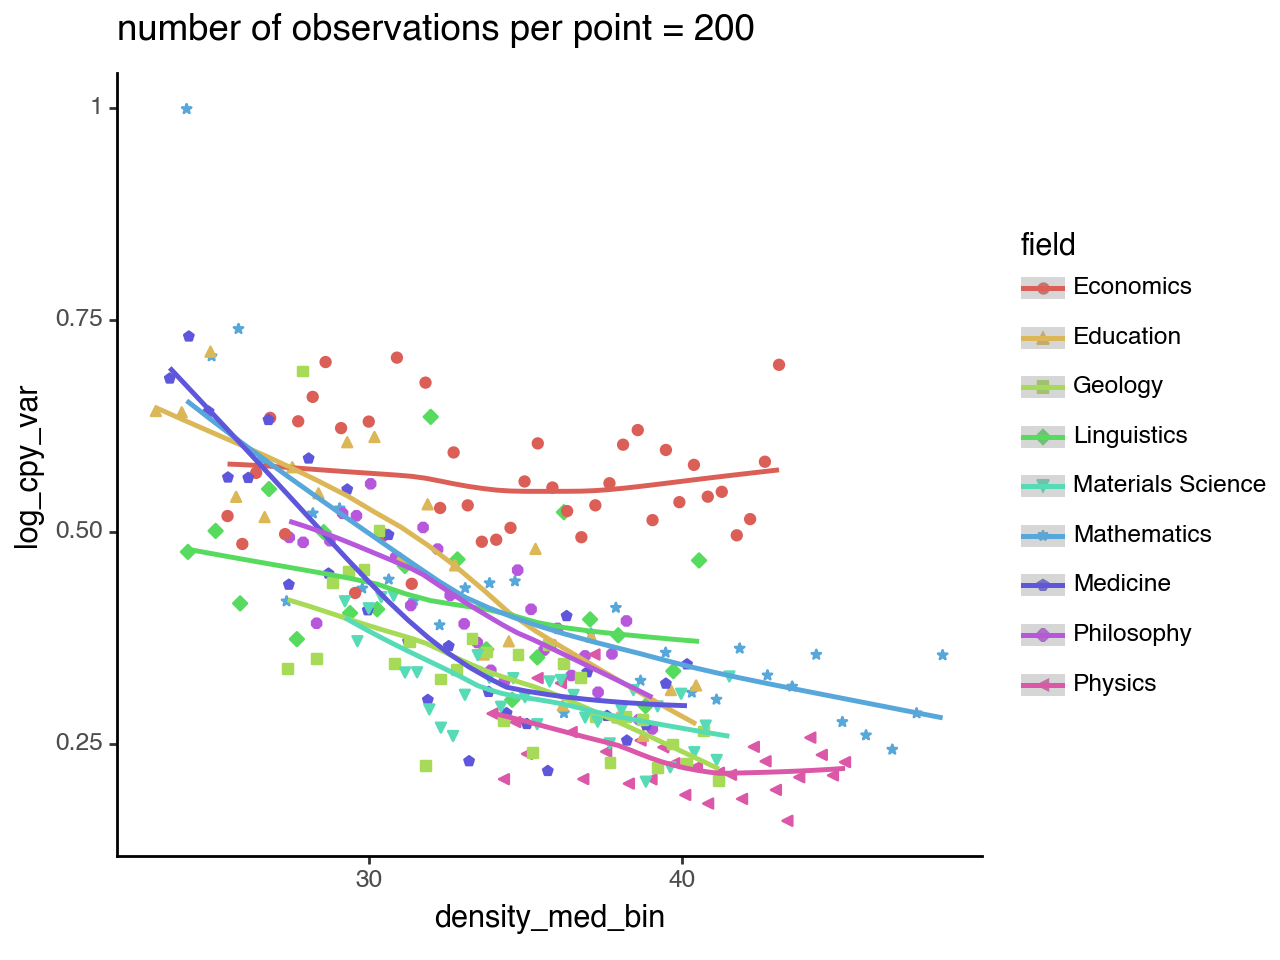

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

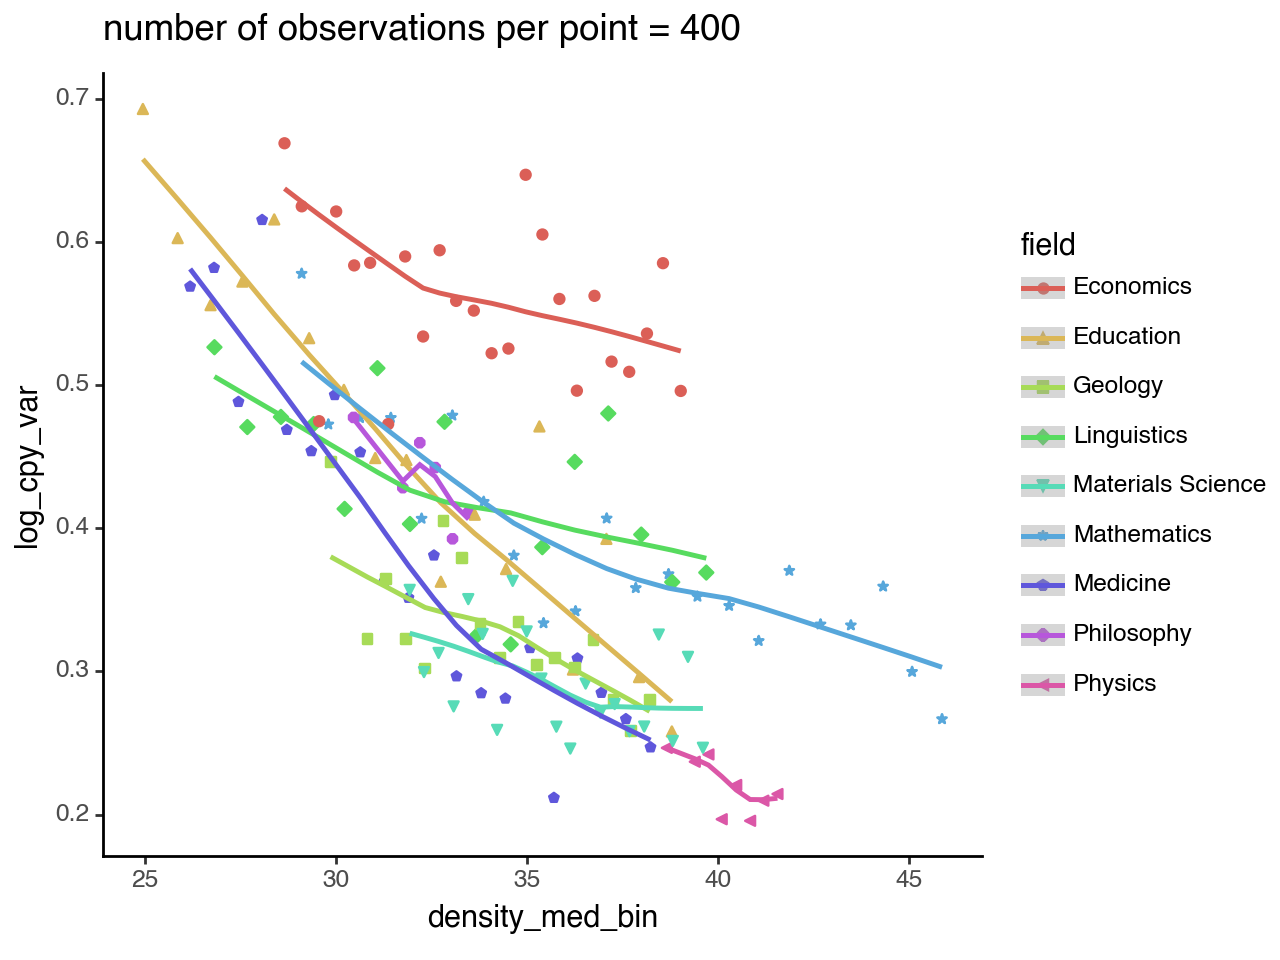

In [24]:
for n_bin in [10, 50, 100, 200, 400]:

    print(
        pn.ggplot(
            pd.concat(
            [get_df_var(df, field, n_bin=n_bin)
            for field in df["fields_of_study_0"].unique()],
            ),
            pn.aes(
                x="density_med_bin",
                # y="log_cpy_med_bin",
                y="log_cpy_var",
                # y="cpy_var",
                # color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                shape="field",
                color="field",
            ),
            # color="black",
            # alpha=0.1,
        )
        + pn.geom_smooth(
            pn.aes(
                color="field",
            )
        )
        # + pn.ylab("Variance in citations per year")
        # + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
        # + pn.ylim(0,2)
        + pn.ggtitle(f"number of observations per point = {n_bin}")
    )

In [25]:
pd.concat(
    [get_df_var(df, field, n_bin=200)
    for field in df["fields_of_study_0"].unique()],
).to_csv("dmb_vs_log_cpy_var.csv", index=False)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [26]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1147396201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,density_bin,freq,count,log_cpy entropy,log_cpy variance,log_cpy median,field
0,15.983,0.002261,33,NaN,0.268737,0.434924,Physics
1,17.798,0.003289,48,NaN,0.519252,0.946125,Physics
2,19.612,0.005002,73,NaN,0.367215,0.570188,Physics
3,21.426,0.007880,115,NaN,0.406818,0.834633,Physics
4,23.241,0.010484,153,NaN,0.375126,0.757625,Physics
5,25.055,0.015965,233,NaN,0.591011,0.586726,Physics
6,26.870,0.023845,348,NaN,0.421951,0.721501,Physics
7,28.684,0.034877,509,NaN,0.513862,0.636822,Physics
8,30.498,0.046320,676,NaN,0.391739,0.648803,Physics
9,32.313,0.059476,868,NaN,0.343405,0.684640,Physics


In [27]:
df_ent_all = pd.concat(
    [get_df_ent(df, field, num_bins=100)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1147396201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1147396201.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1147396201.py:38: RuntimeWarning: All-NaN slice encountered
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1147396201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/

,density_bin,freq,count,log_cpy entropy,log_cpy variance,log_cpy median,field
0,15.983,0.000137,2,NaN,NaN,NaN,Physics
1,16.346,0.000343,5,NaN,0.000000,6.863809e-01,Physics
2,16.709,0.000685,10,NaN,0.150047,5.756338e-01,Physics
3,17.072,0.000343,5,NaN,NaN,NaN,Physics
4,17.435,0.000754,11,NaN,0.306047,-2.775558e-17,Physics
...,...,...,...,...,...,...,...
95,89.806,0.000000,0,NaN,NaN,NaN,Mathematics
96,90.611,0.000056,1,NaN,NaN,NaN,Mathematics
97,91.416,0.000000,0,NaN,NaN,NaN,Mathematics
98,92.222,0.000000,0,NaN,NaN,NaN,Mathematics


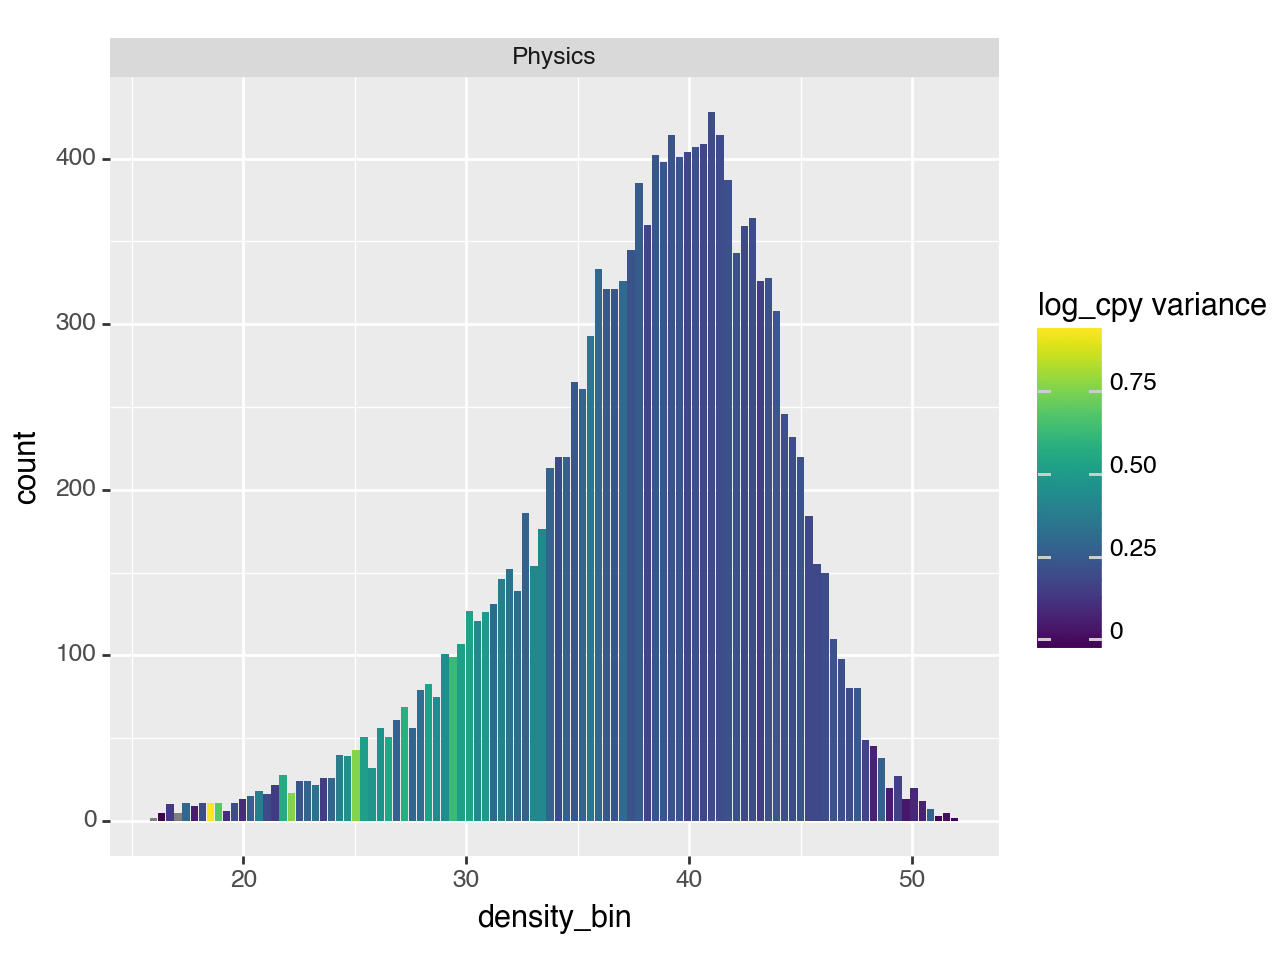

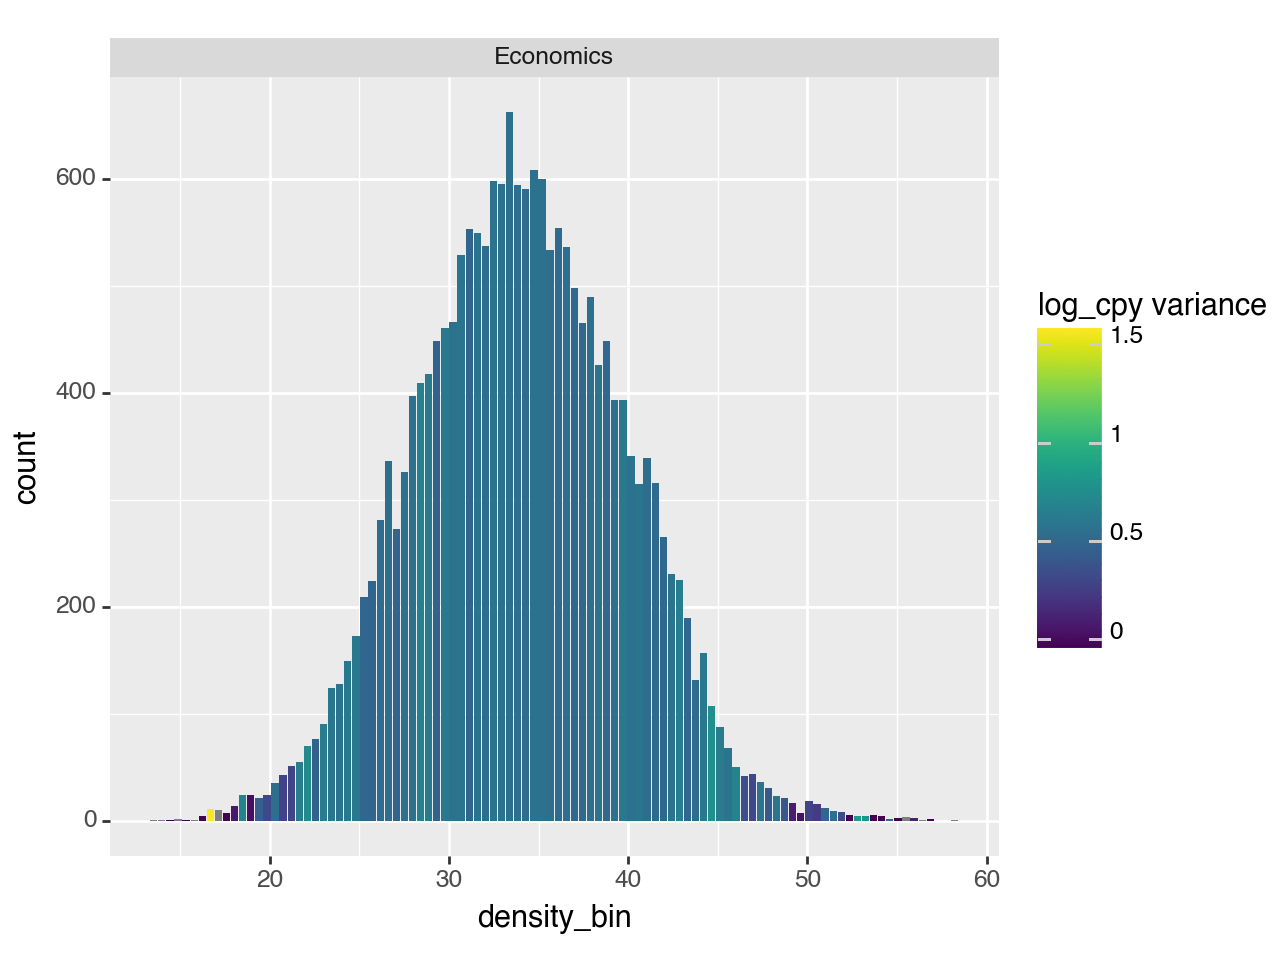

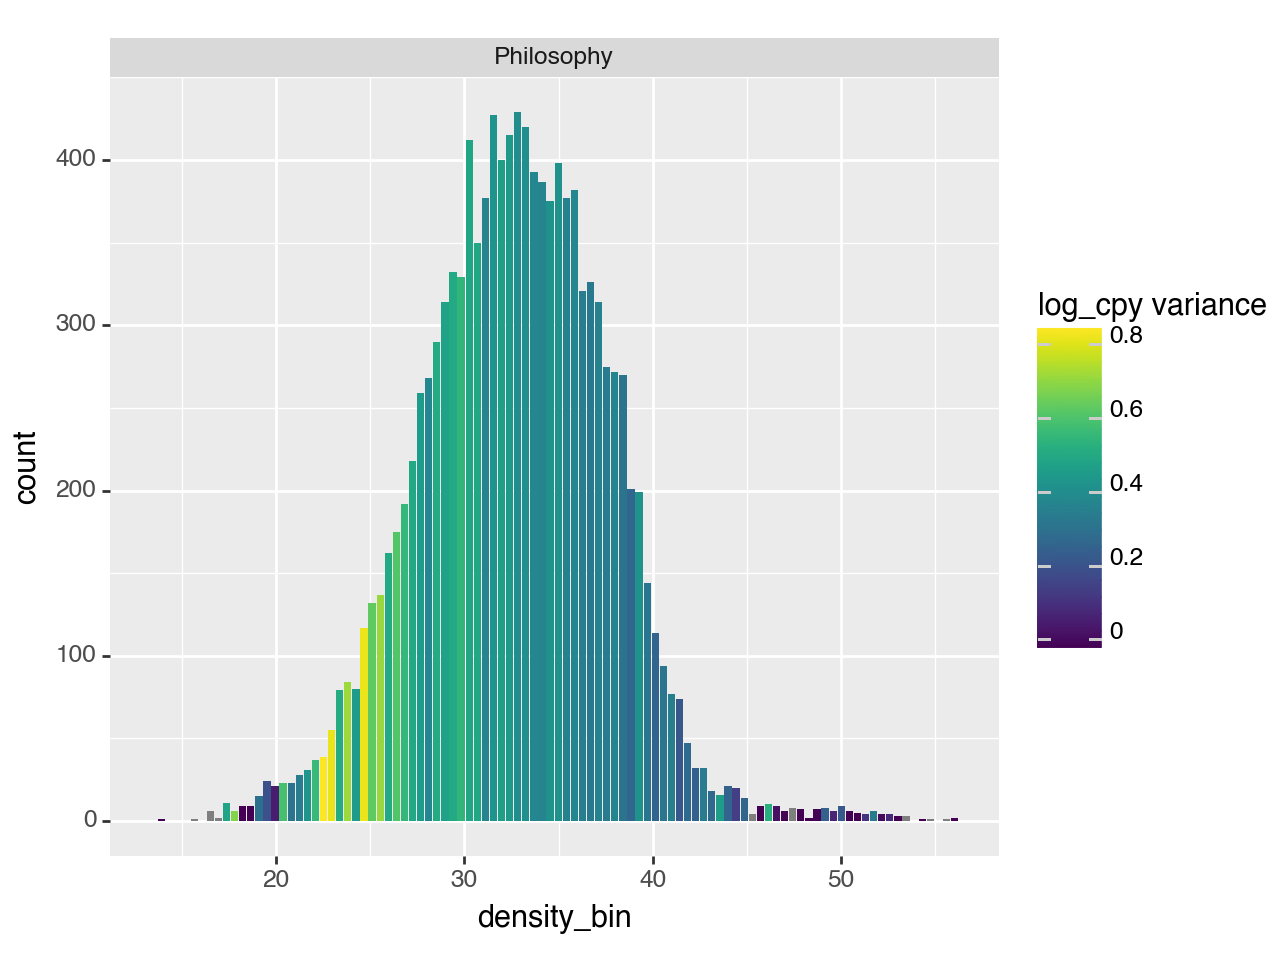

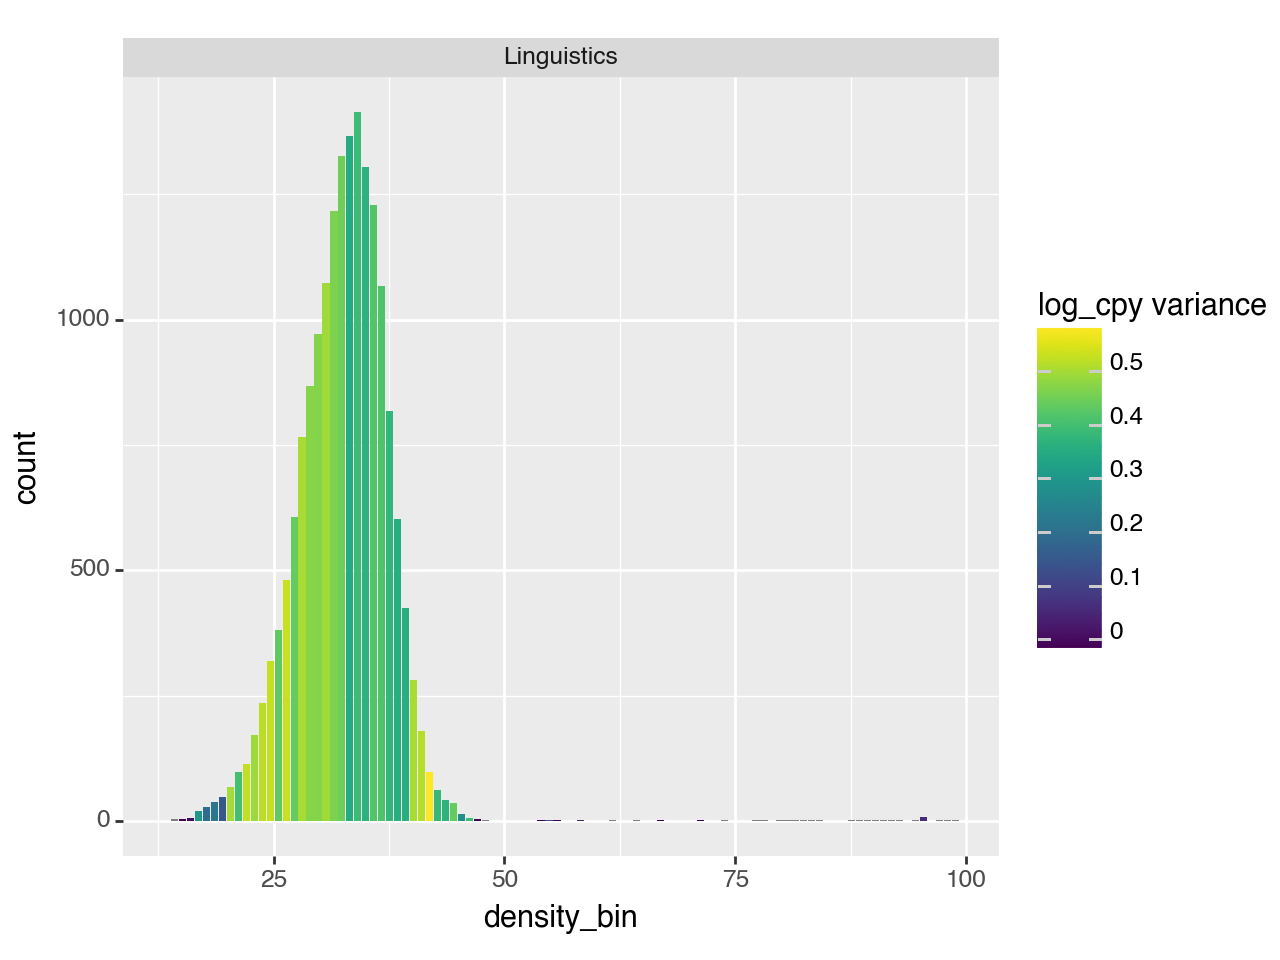

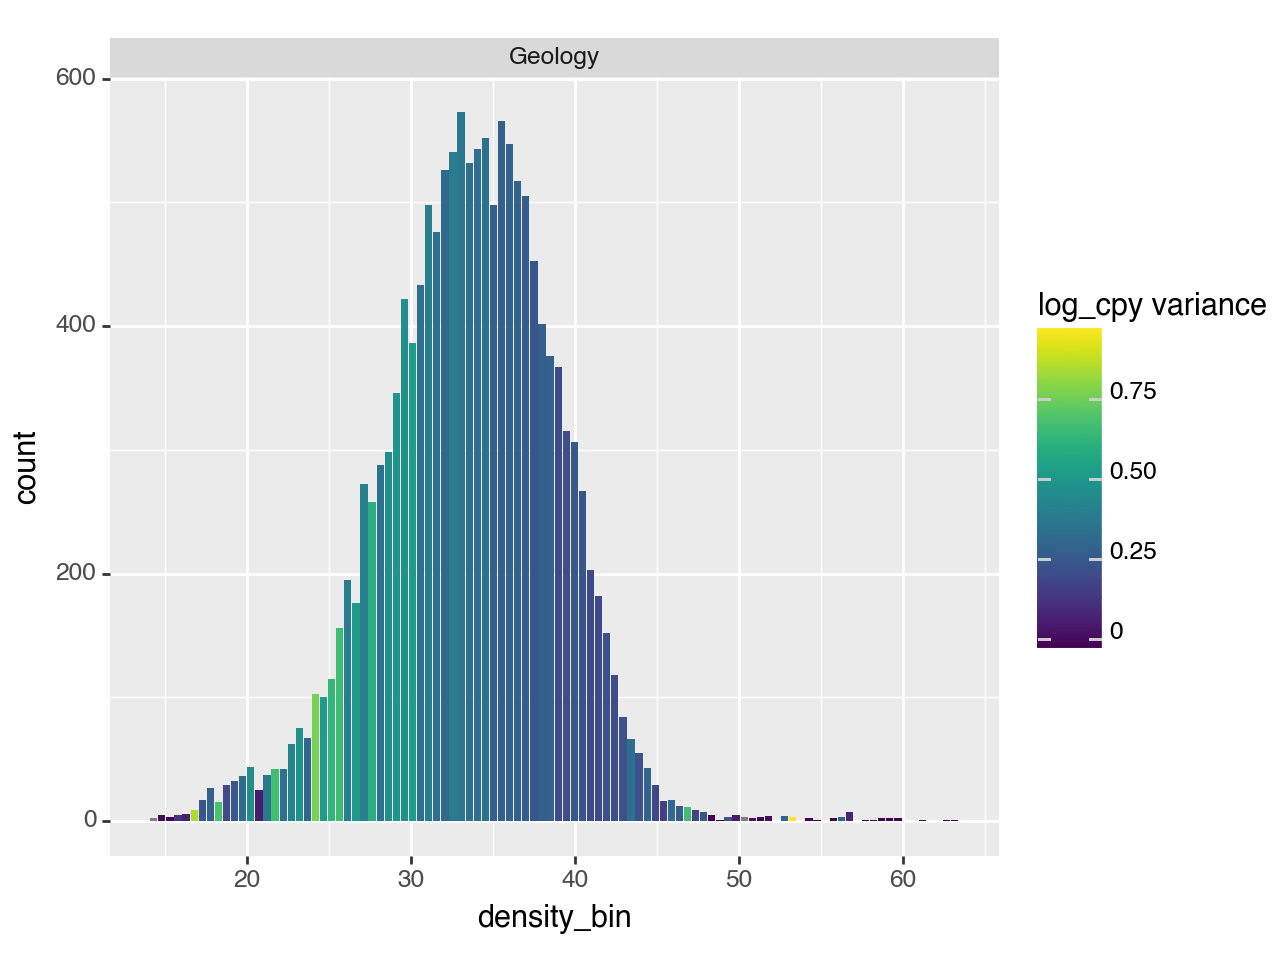

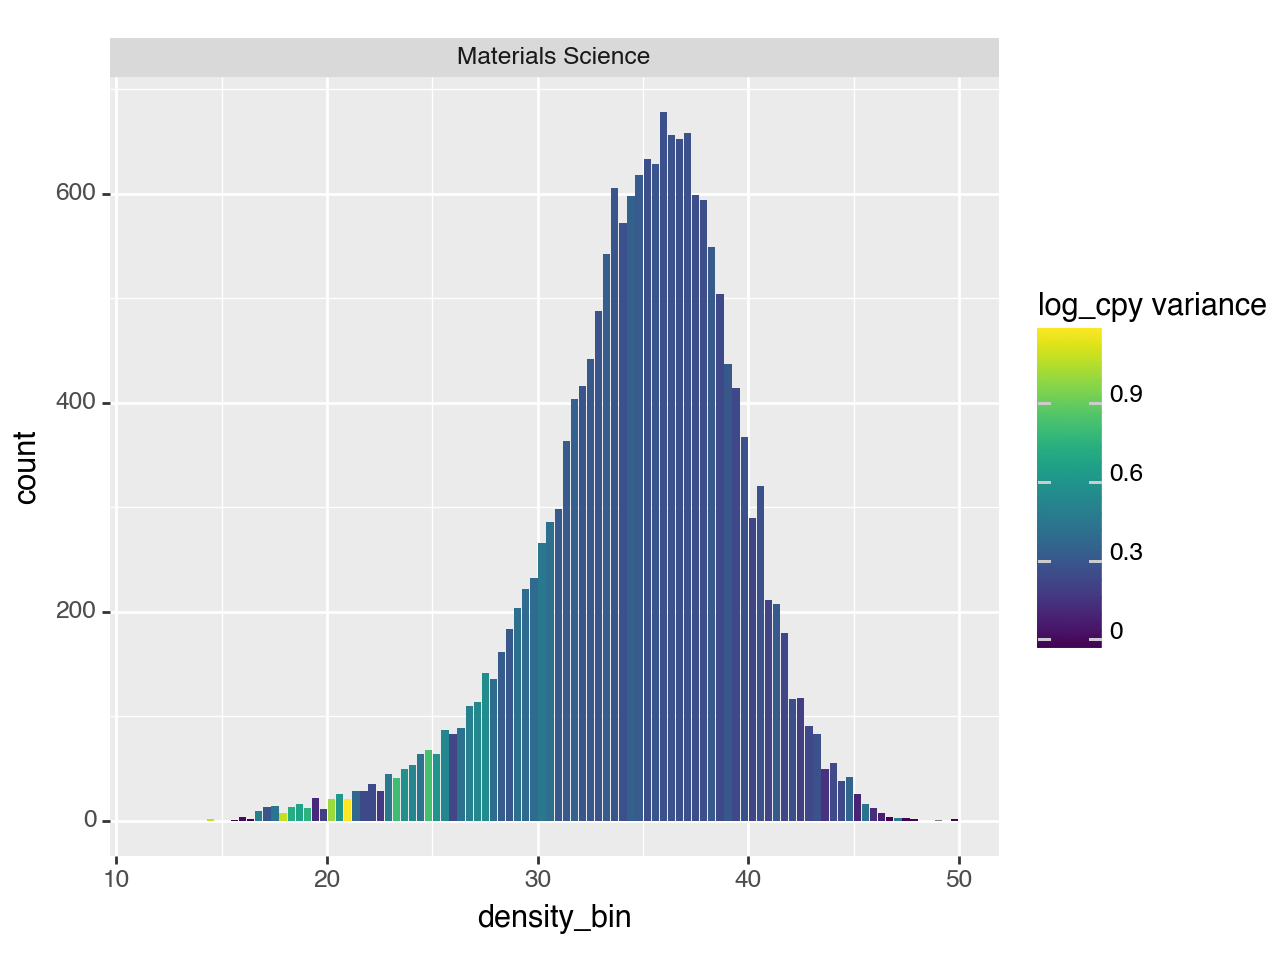

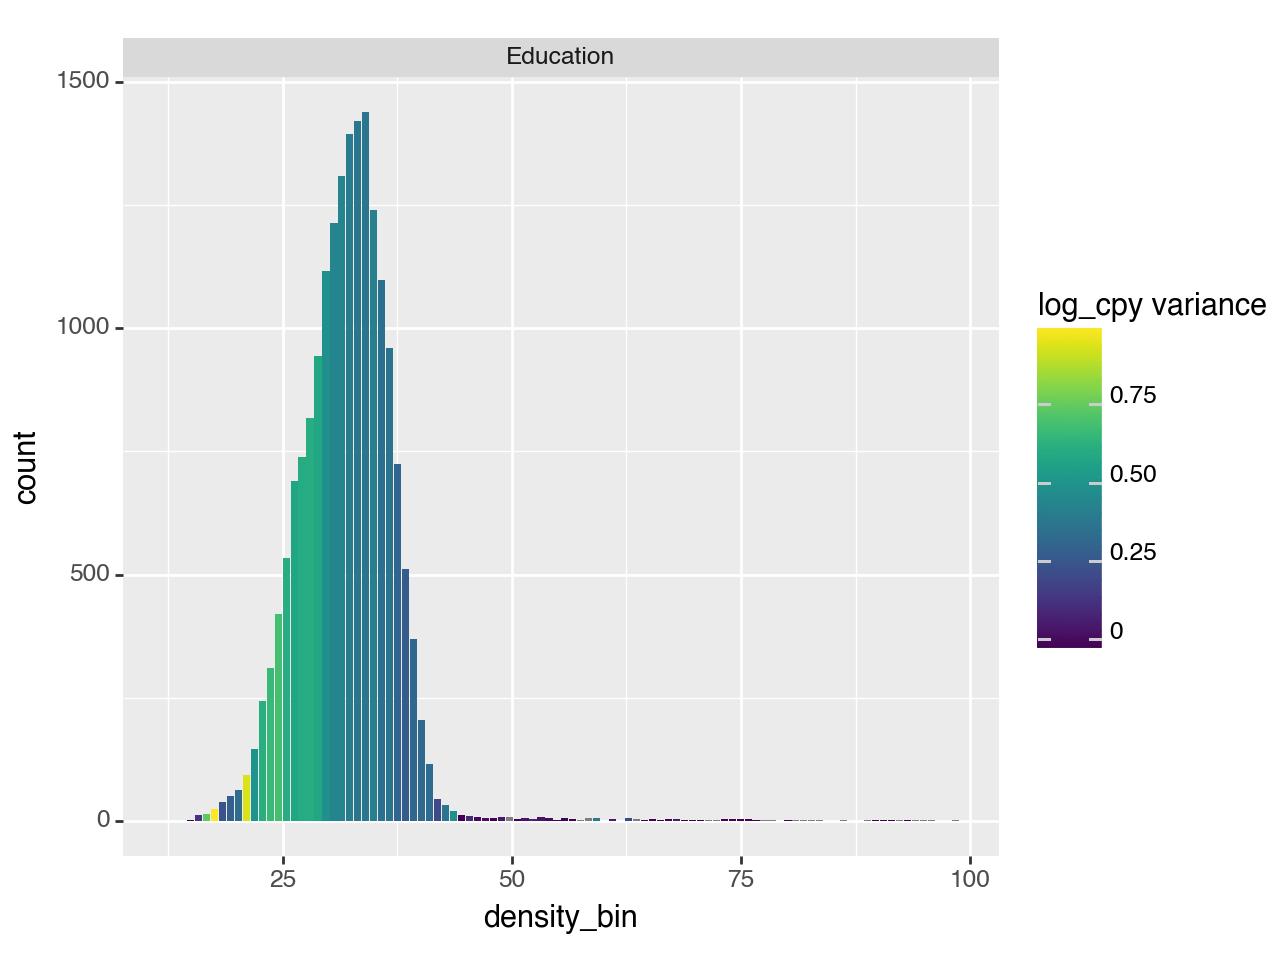

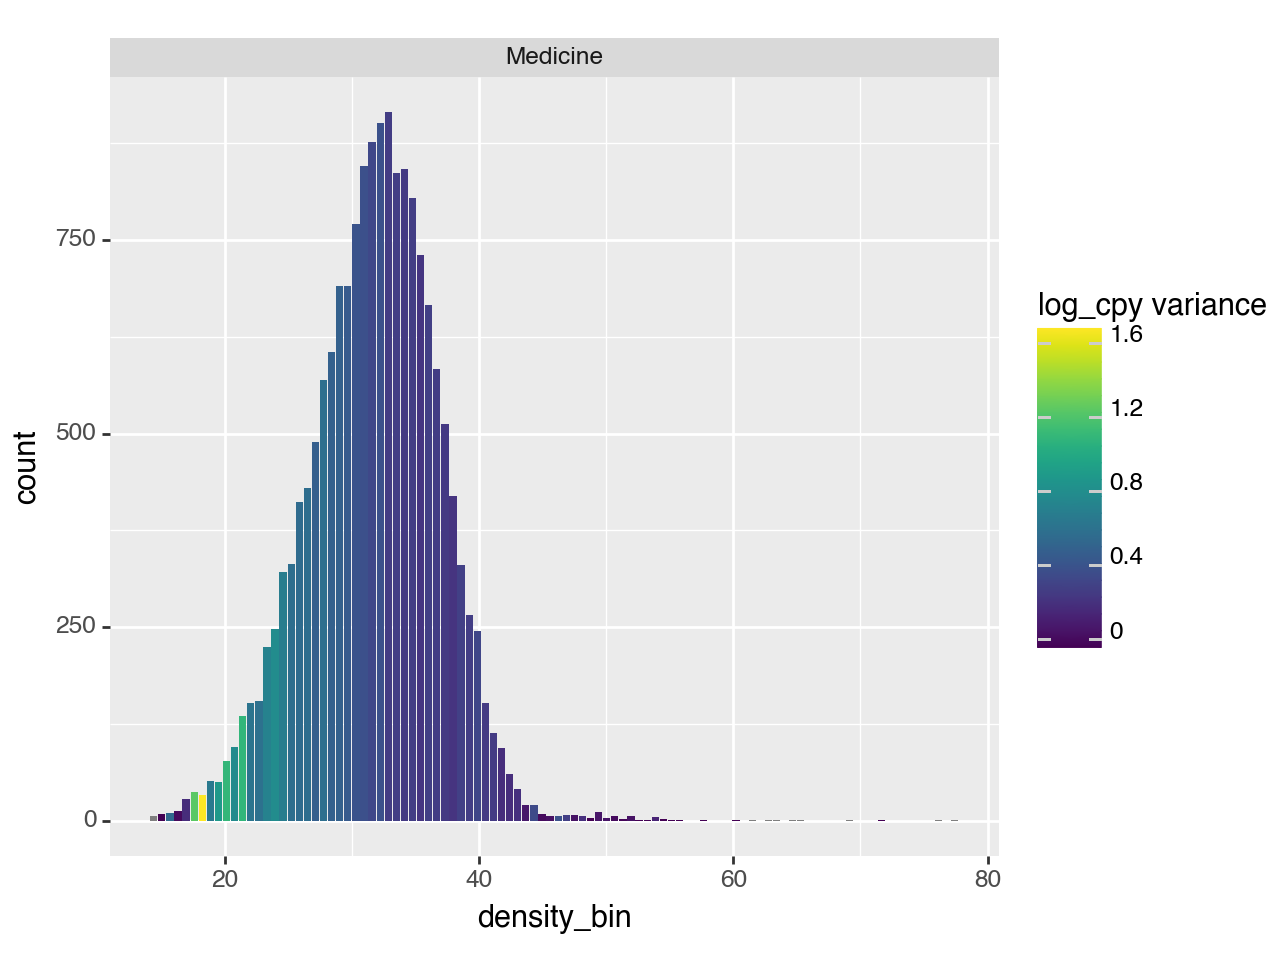

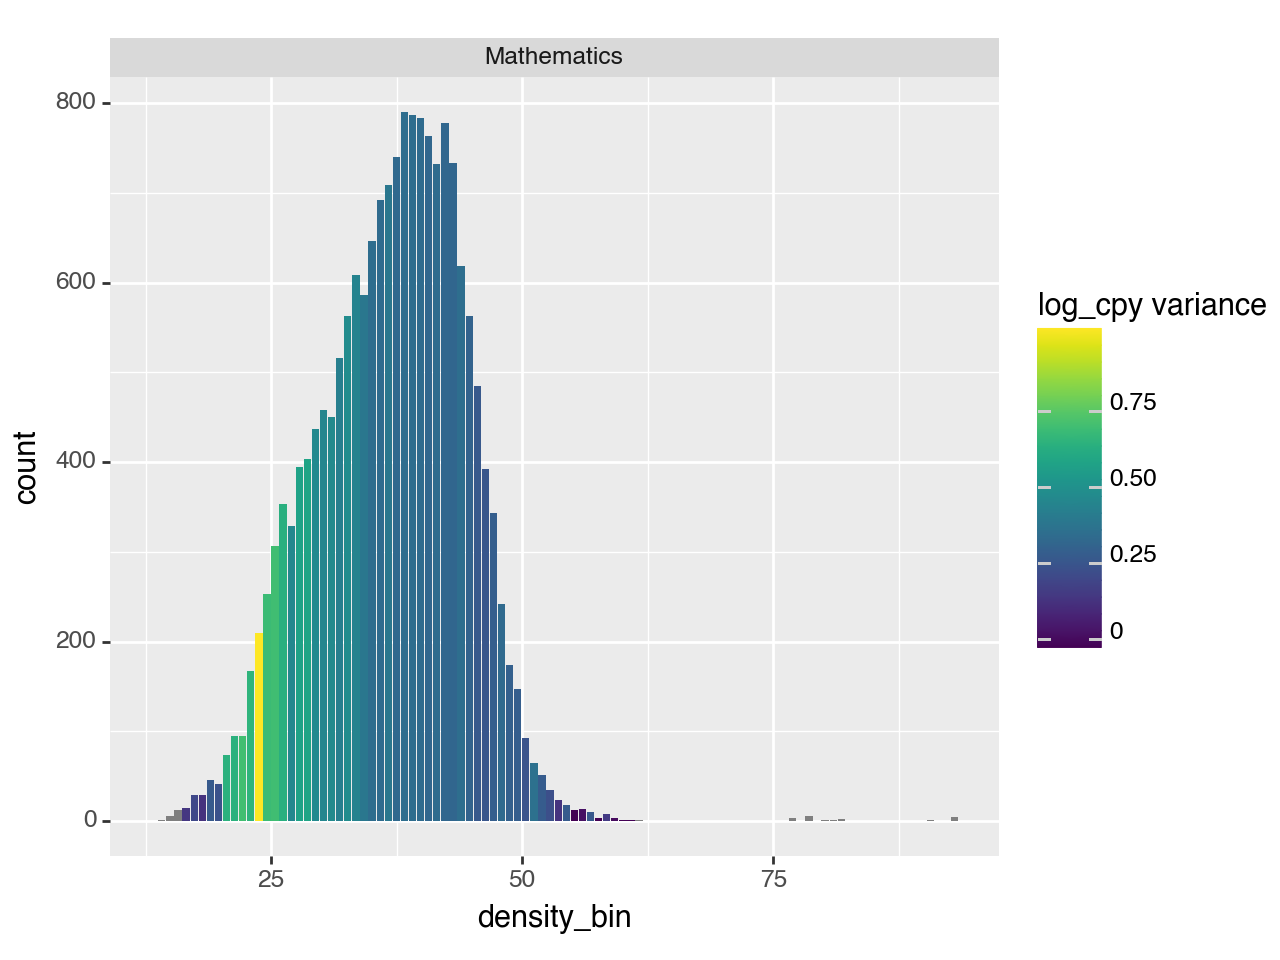

In [28]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            fill="log_cpy variance",
            # fill="log_cpy median",
            y="count",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
    )


In [29]:
df_ent_all["log_cpy_variance"] = df_ent_all["log_cpy variance"]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/cit

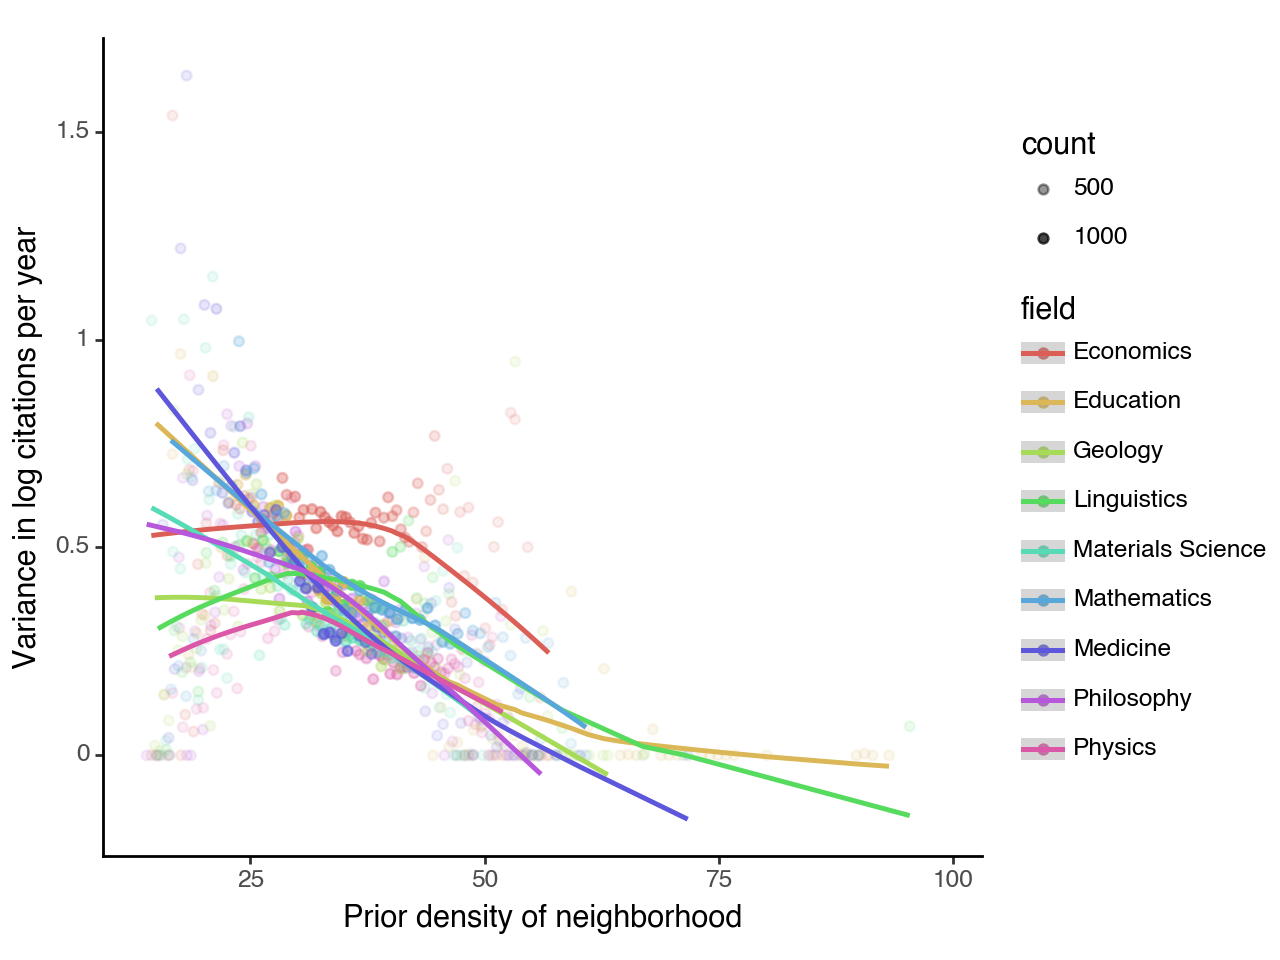

<Figure Size: (640 x 480)>

In [43]:
from scipy.stats import linregress

(
        pn.ggplot(
            df_ent_all[df_ent_all["count"] > 0], 
            pn.aes(
                x="density_bin",
                y="log_cpy variance",
                color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                # size="freq",
                alpha="count",      
            )
        )
        + pn.geom_smooth(
            pn.aes(
                # color="field",
            ),
            # color="black",
        )
        + pn.ylab("Variance in log citations per year")
        + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
)

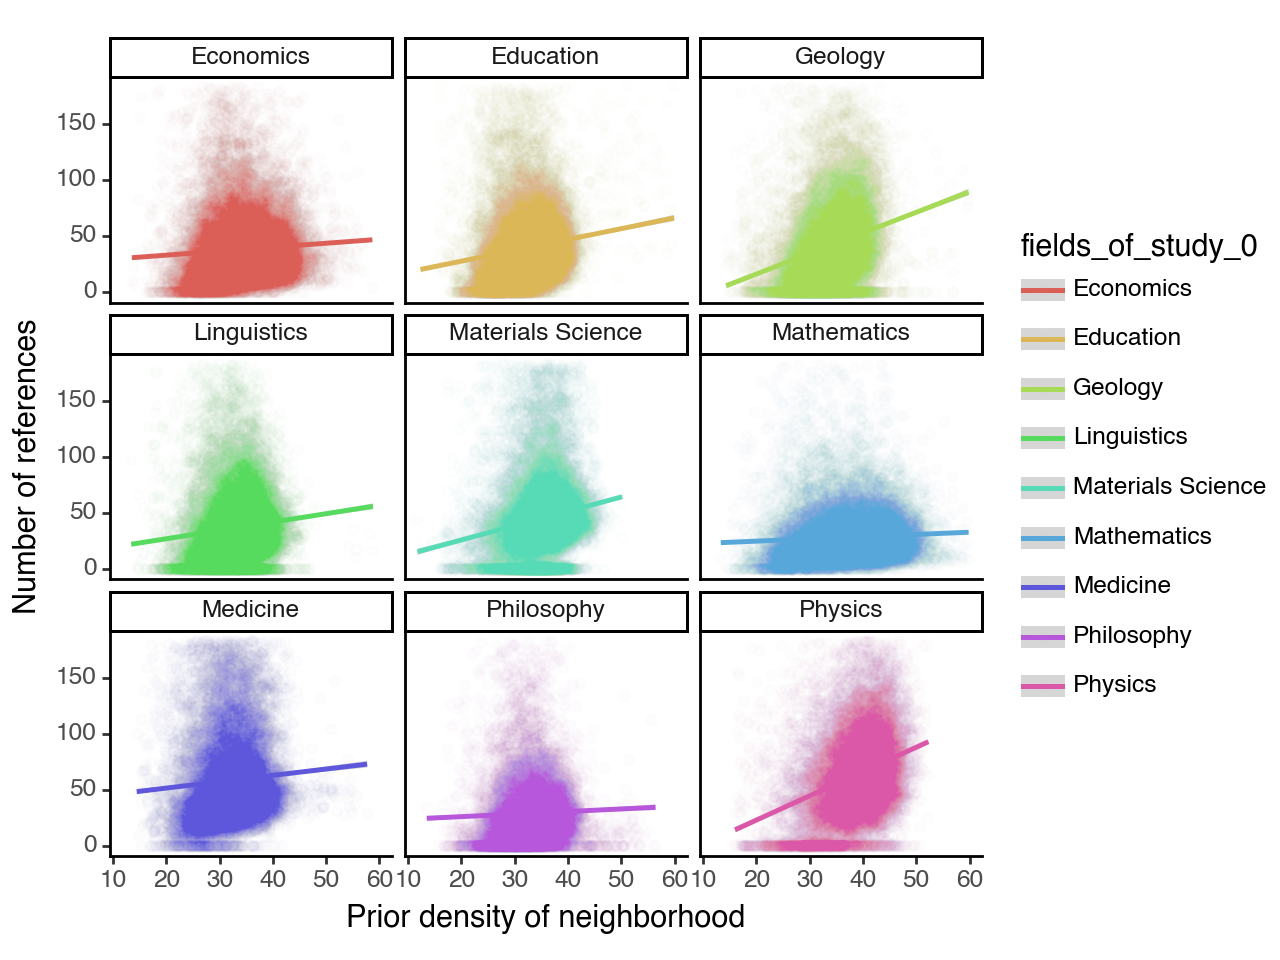

<Figure Size: (640 x 480)>

In [31]:
# Let's visualize reference length for all fields.

df_temp =  df[df["density"] < 60]
df_temp = df_temp[df_temp.references < (df_temp.references.mean())+2*df_temp.references.std()]

(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.xlab("Prior density of neighborhood")
    + pn.ylab("Number of references")
    + pn.theme_classic()
    # TODO: annotate each line with R^2, p-values
    # TODO: normalize each by the average number of references per field
)

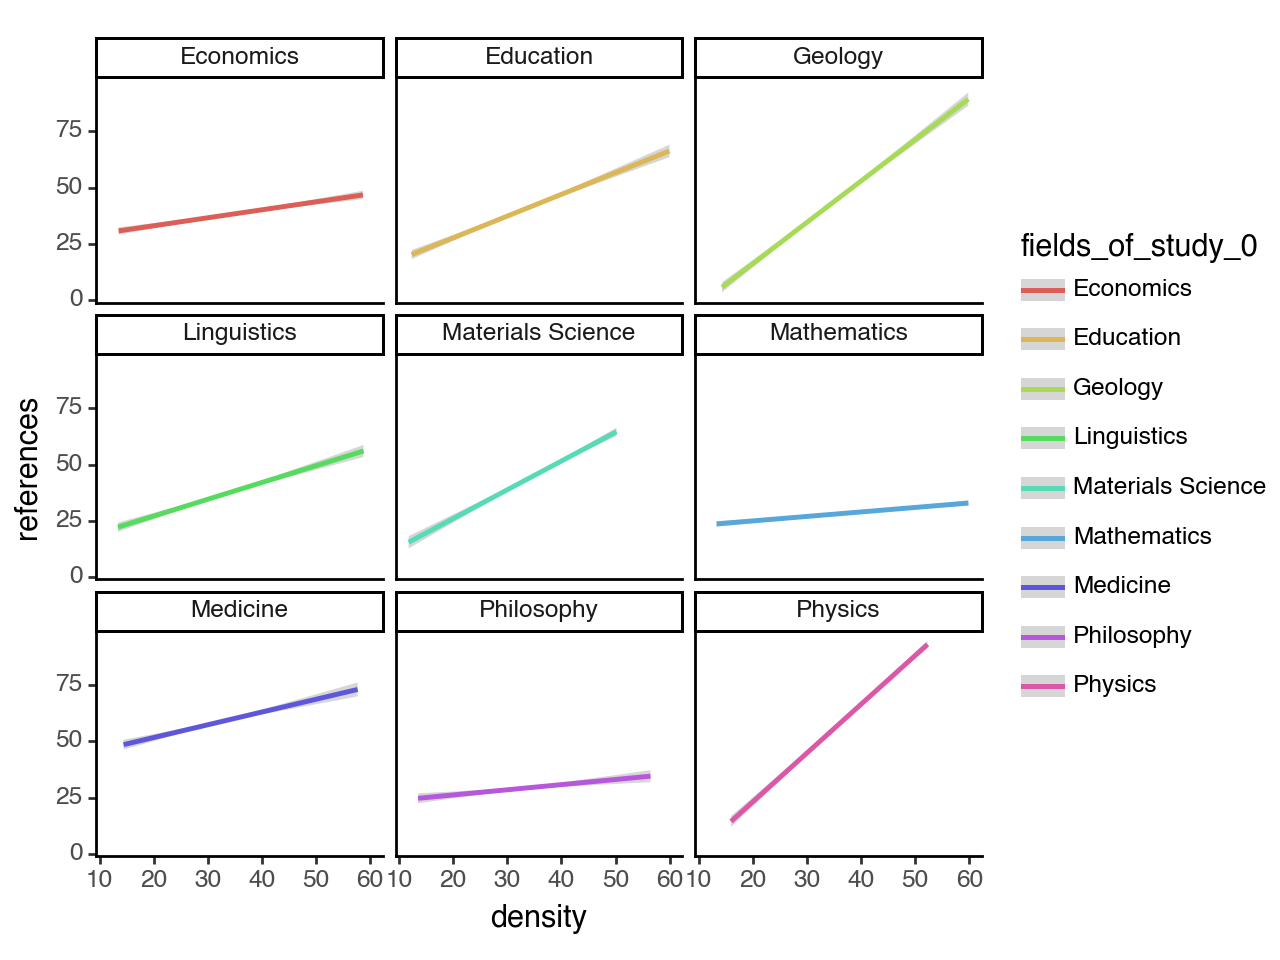

<Figure Size: (640 x 480)>

In [32]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            # x="references",
            # y="log_cpy",
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    # + pn.geom_point(alpha=0.01)
    # + pn.geom_hline( pn.aes(yintercept=df_temp.log_cpy.median().item()) )
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

In [33]:
# try in R, maybe its prettier.
df_ent_all.to_csv("all_cpy_variance_data.csv", index=False)

#### Zach style main trend plot from ads paper

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/3898421221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

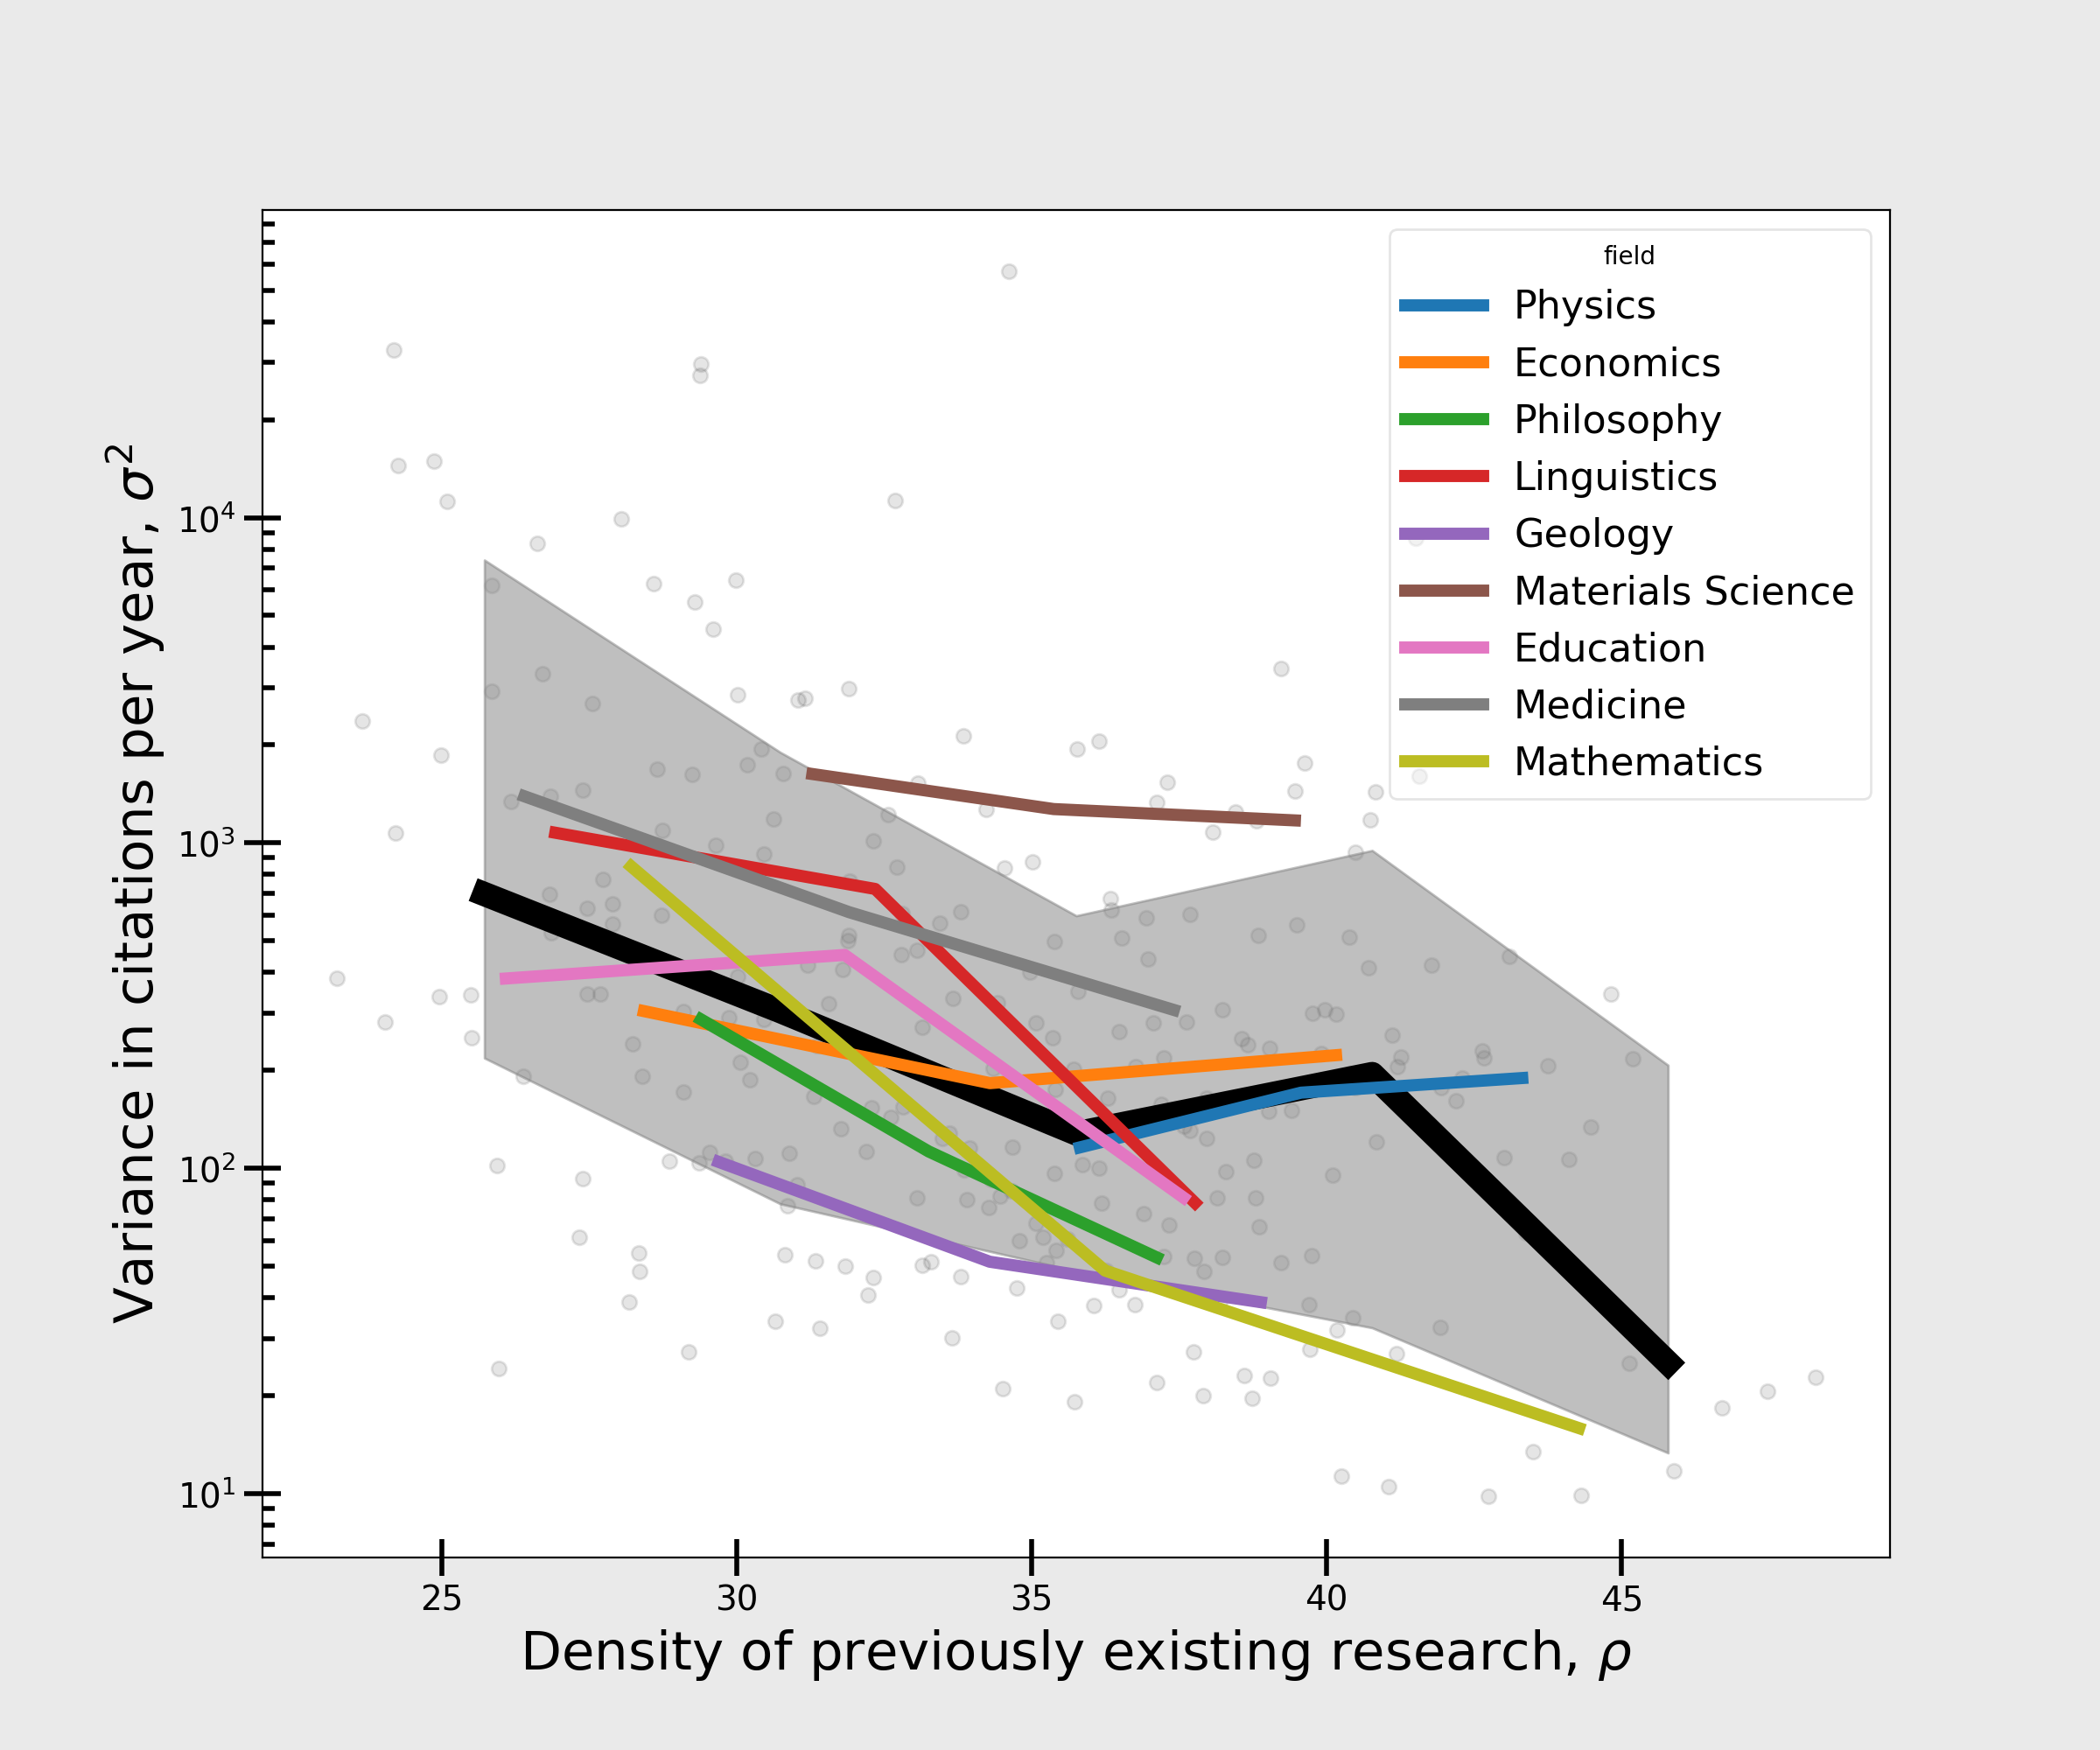

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import scipy


# df_mpl = pd.read_csv("dmb_vs_log_cpy_var.csv")
df_mpl = pd.concat(
    [get_df_var(df, field, n_bin=200)
    for field in df["fields_of_study_0"].unique()],
)


facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()

e_n = df_mpl["density_med_bin"]

mult = 1.

cpy_v = df_mpl["cpy_var"]
ax.scatter(
    mult * e_n,
    cpy_v,
    color = 'k',
    alpha = 0.1,
)

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    6,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.5,
)
ax.plot(
    mult * xs,
    median,
    linewidth = 10,
    color = "black",
)

# add fields
fields = df_mpl.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_mpl[df_mpl["field"] == field]

    e_n = df_field["density_med_bin"]

    cpy_v = df_field["cpy_var"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    # ax.scatter(
    #     mult * e_n,
    #     cpy_v,
    #     alpha = 0.4,
    #     # label=field,
    # )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor,
    # edgecolor = 'white',
    framealpha = 0.5,
)

ax.set_yscale( 'log' )

# Axis labels
ax.set_ylabel( r'Variance in citations per year, $\sigma^2$', fontsize=22 )
ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Because the plotting data involves sampling, there are a lot of spurious researcher degrees of freedom in selecting which trends to show! Because some of these fields are only slighltly decreasing in variance, esp economics, and linguistics, it's important to reflect that, but it's also important to not just sample the best looking plot for our story. Need some more principled way of plotting the relationship.